In [1]:
import sys, os, subprocess, shutil, glob, pathlib

print("Python:", sys.version)
print("Interpreter:", sys.executable)

env_name = os.path.basename(sys.prefix) or "current-env"
print("Detected environment name:", env_name)

req_file = "requirements.txt"
if os.path.exists(req_file):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", req_file])
else:
    subprocess.check_call([sys.executable, "-m", "pip", "install",
                           "numpy==1.23.5", "scipy==1.15.3",
                           "parmap==1.7.0", "pandas==2.3.1",
                           "scikit-learn==1.7.1"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "setuptools>=68", "wheel", "Cython<3.1"])
subprocess.check_call([sys.executable, "-m", "ipykernel", "install",
                       "--user", "--name", env_name, "--display-name", f"Python ({env_name})"])

for p in ["build", "__pycache__"]:
    shutil.rmtree(p, ignore_errors=True)
for f in glob.glob("ns_hmm.*.so") + glob.glob("ns_hmm.*.pyd") + glob.glob("ns_hmm.c"):
    pathlib.Path(f).unlink(missing_ok=True)

for key in ("CFLAGS", "CPPFLAGS", "CXXFLAGS"):
    if key in os.environ:
        os.environ.pop(key)

if os.path.exists("setup.py"):
    print("\n[Build] python setup.py build_ext --inplace ...")
    subprocess.check_call([sys.executable, "setup.py", "build_ext", "--inplace"])
else:
    raise FileNotFoundError("setup.py not found in current directory.")

import importlib
try:
    import ns_hmm
except Exception:
    if "ns_hmm" in sys.modules:
        del sys.modules["ns_hmm"]
    importlib.invalidate_caches()
    import ns_hmm

print("\nSetup complete. ns_hmm loaded:", ns_hmm)
print(f"Jupyter kernel registered as: Python ({env_name})")


Python: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
Interpreter: /opt/anaconda3/envs/MSH_Bayes/bin/python3.10
Detected environment name: MSH_Bayes
Installed kernelspec MSH_Bayes in /Users/seongyu/Library/Jupyter/kernels/msh_bayes

[Build] python setup.py build_ext --inplace ...
Compiling ns_hmm.pyx because it changed.
[1/1] Cythonizing ns_hmm.pyx
running build_ext
building 'ns_hmm' extension
creating build/temp.macosx-11.1-arm64-cpython-310
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/MSH_Bayes/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/MSH_Bayes/include -arch arm64 -I/opt/anaconda3/envs/MSH_Bayes/lib/python3.10/site-packages/numpy/core/include -I/opt/anaconda3/envs/MSH_Bayes/include/python3.10 -c ns_hmm.c -o build/temp.macosx-11.1-arm64-cpython-310/ns_hmm.o -Wno-unreachable-code-fallthrough -O3 -Wno-cpp
creating build/lib.macosx-11.1-arm64-cpython-310
clang -bundle -undefined dyna

ld: warning: duplicate -rpath '/opt/anaconda3/envs/MSH_Bayes/lib' ignored



Setup complete. ns_hmm loaded: <module 'ns_hmm' from '/Users/seongyu/Desktop/research/Multi-state-BM-main/ns_hmm.cpython-310-darwin.so'>
Jupyter kernel registered as: Python (MSH_Bayes)


In [17]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import math
import seaborn as sns
from matplotlib import gridspec
import multiprocessing
from multiprocessing import get_context
import parmap
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
from sklearn.mixture import BayesianGaussianMixture as BGMM
import sys, subprocess, shutil, glob, pathlib, os, site, platform, threading
import pickle
print("Python:", sys.version)
print("Interpreter:", sys.executable)
print("Site-packages:", site.getsitepackages())
print("OS:", platform.platform())

Python: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
Interpreter: /opt/anaconda3/envs/MSH_Bayes/bin/python3.10
Site-packages: ['/opt/anaconda3/envs/MSH_Bayes/lib/python3.10/site-packages']
OS: macOS-15.3.2-arm64-arm-64bit


In [3]:
plt.rcParams["font.family"] = "times new roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 75
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20 

from matplotlib_inline.backend_inline import set_matplotlib_formats

# Nested sampling run

In [41]:
# user-configurable parameters
user_params = {
    "D_min": 0.001,
    "D_max": 2.0,
    "unit_T": 0.1,
    "unit_L": 0.167,
}
path = 'test_dataset'

ns_hmm.set_params(user_params)
fnames = np.genfromtxt(f'{path}/filenames.txt', dtype=str)
print(ns_hmm.get_params())  # check

{'D_min': 0.001, 'D_max': 2.0, 'unit_T': 0.1, 'unit_L': 0.167}


In [42]:
fnum = len(fnames)
findices = np.arange(1, fnum + 1)
num_cores = min(os.cpu_count(), fnum)
indices = np.array_split(findices, num_cores)

print(fnames)
for i in range(fnum):
    globals()[f'trj_{i+1}'] = np.genfromtxt(f'{path}/{fnames[i]}')

['trj1.txt' 'trj2.txt' 'trj3.txt' 'trj4.txt' 'trj5.txt' 'trj6.txt'
 'trj7.txt' 'trj8.txt' 'trj9.txt' 'trj10.txt' 'trj11.txt' 'trj12.txt'
 'trj13.txt' 'trj14.txt' 'trj15.txt' 'trj16.txt' 'trj17.txt' 'trj18.txt'
 'trj19.txt' 'trj20.txt' 'trj21.txt' 'trj22.txt' 'trj23.txt' 'trj24.txt'
 'trj25.txt' 'trj26.txt' 'trj27.txt' 'trj28.txt']


In [ ]:
fnum = len(fnames)
findices = np.arange(1, fnum + 1)
num_cores = min(os.cpu_count(), fnum)
indices = np.array_split(findices, num_cores)

print(fnames)
for i in range(fnum):
    globals()[f'trj_{i+1}'] = np.genfromtxt(f'{path}/{fnames[i]}')

def start_logger(ctx):
    mgr = ctx.Manager()
    q = mgr.Queue()
    def _listener():
        for msg in iter(q.get, None):
            print(msg, flush=True)
    t = threading.Thread(target=_listener, daemon=True)
    t.start()
    return q, t, mgr

start_method = "fork" if sys.platform != "win32" else "spawn"
ctx = get_context(start_method)

USE_LOG_QUEUE = True
log_q, t, mgr = (None, None, None)
if USE_LOG_QUEUE:
    log_q, t, mgr = start_logger(ctx)

def _init_worker(params):
    import ns_hmm as _m
    _m.set_params(params)

with ctx.Pool(processes=num_cores, initializer=_init_worker, initargs=(user_params,)) as pool:
    results = parmap.map(
        ns_hmm.mp_nested_sampling,
        indices,
        200, 100000, 0.0001, 0.25, 30, path,
        log_q=log_q,
        pm_pbar=True, pm_pool=pool
    )

if USE_LOG_QUEUE:
    log_q.put(None)
    t.join()


['trj1.txt' 'trj2.txt' 'trj3.txt' 'trj4.txt' 'trj5.txt' 'trj6.txt'
 'trj7.txt' 'trj8.txt' 'trj9.txt' 'trj10.txt' 'trj11.txt' 'trj12.txt'
 'trj13.txt' 'trj14.txt' 'trj15.txt' 'trj16.txt' 'trj17.txt' 'trj18.txt'
 'trj19.txt' 'trj20.txt' 'trj21.txt' 'trj22.txt' 'trj23.txt' 'trj24.txt'
 'trj25.txt' 'trj26.txt' 'trj27.txt' 'trj28.txt']
log(Z_remain / Z): 404.3877242090375
log(Z_remain / Z): 313.0116270932796
log(Z_remain / Z): 54.514269593648905
log(Z_remain / Z): 313.8158165986082
log(Z_remain / Z): 215.27706689091076
log(Z_remain / Z): 257.63170265616657
log(Z_remain / Z): 629.4332354798499
log(Z_remain / Z): 271.9857609514428
log(Z_remain / Z): 3.110554397394788
log(Z_remain / Z): 2.454831514984793
log(Z_remain / Z): 32.21821114747075
log(Z_remain / Z): 19.716993829888484
log(Z_remain / Z): 1.0516079872209732
log(Z_remain / Z): 1.577629064504749
log(Z_remain / Z): 66.83277610019138
log(Z_remain / Z): 26.114547769879156
log(Z_remain / Z): 0.5300442834371788
log(Z_remain / Z): 0.0895234411

# AIC calculation

In [19]:
AIC = np.zeros((fnum, 3))
for j in range(fnum):
    temp_AIC = np.inf
    for k in range(3):
        nstates = k + 1
        with open('{}/results/{}totalseries{}state.pkl'.format(path, j+1, nstates), 'rb') as f:
            temp = pickle.load(f)
        temp_MLE = temp[np.argmax(temp[:, nstates**2]), :]
        AIC[j, k] = 2 * (nstates ** 2) - 2 * temp_MLE[nstates ** 2]
        
        if AIC[j, k] < temp_AIC: # model selection
            temp_AIC = AIC[j, k]
            globals()['MLE{}'.format(j+1)] = temp_MLE.copy() # MLE with minimum AIC

with open('{}/results/AIC.pkl'.format(path), 'wb') as f:
    pickle.dump(AIC, f)
        

# Model selection

In [20]:
model_AIC = np.zeros(fnum, dtype = int)
with open('{}/results/AIC.pkl'.format(path), 'rb') as f:
    IC = pickle.load(f)
model_AIC = np.argmin(IC, axis = 1) + 1
            
model_Bayes = np.zeros(fnum, dtype = int)
for i in range(fnum):
    with open('{}/results/prob{}.pkl'.format(path, i + 1), 'rb') as f:
        prob = pickle.load(f)
    model_Bayes[i] = np.argmax(prob) + 1

In [21]:
model_AIC

array([2, 2, 2, 1, 2])

# Parameter estimation (MLE, MAP)

In [22]:
ns_hmm.NS_Params('uniform', 'AIC', path, fnum)
ns_hmm.NS_Params('uniform', 'Bayesian', path, fnum)

0

In [23]:
AIC_MLE_ds = []
AIC_MAP_ds = []
cnt = 0

####--AIC, MLE

for j in range(fnum):
    with open('{}/results/MLE{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
        temp = pickle.load(f)
    temp = temp.flatten()
    for k in range(np.sqrt(len(temp)-1).astype(int)):
        AIC_MLE_ds.append(temp[k])
        
####--AIC, MLE

####--AIC, MAP

for j in range(fnum):
    with open('{}/results/MAP{}_{}.pkl'.format(path, j+1, 'AIC'), 'rb') as f:
        temp = pickle.load(f)
    temp = temp.flatten()
    for k in range(np.sqrt(len(temp)-1).astype(int)):
        AIC_MAP_ds.append(temp[k])

####--AIC, MAP

In [24]:
Bayes_MLE_ds = []
Bayes_MAP_ds = []
cnt = 0

####--Bayes, MLE

for j in range(fnum):
    with open('{}/results/MLE{}_{}.pkl'.format(path, j+1, 'Bayesian'), 'rb') as f:
        temp = pickle.load(f)
    temp = temp.flatten()
    for k in range(np.sqrt(len(temp)-1).astype(int)):
        Bayes_MLE_ds.append(temp[k])
        
####--Bayes, MLE


####--Bayes, MAP

for j in range(fnum):
    with open('{}/results/MAP{}_{}.pkl'.format(path, j+1, 'Bayesian'), 'rb') as f:
        temp = pickle.load(f)
    temp = temp.flatten()
    for k in range(np.sqrt(len(temp)-1).astype(int)):
        Bayes_MAP_ds.append(temp[k])

####--Bayes, MAP

# Parameter clustering

### AIC

5
weight: 0.4489903079617454
mu: 0.36024449085130195
var: 0.07534378385702012
4
weight: 0.36378555417324254
mu: 0.0389928421929365
var: 0.09764533133280558
0
weight: 0.09733011222290662
mu: 0.1331933158965641
var: 0.06114509499883531
0
weight: 0.0898940256421056
mu: 0.132346540582497
var: 0.06101069205692732
5
weight: 0.46372536706524026
mu: 0.35008251655001865
var: 0.08047243124616003
4
weight: 0.3320356254728488
mu: 0.036372084640509124
var: 0.10682667903917503
0
weight: 0.10776063740943645
mu: 0.141911578434196
var: 0.05967344204884565
0
weight: 0.09647837005247457
mu: 0.14072378100935795
var: 0.05974345095431351


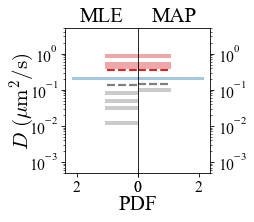

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.mixture import BayesianGaussianMixture as BGMM
from scipy.stats import norm
import pickle

def _prep_positive_log10(arr, name="array"):
    arr = np.asarray(arr, dtype=float).ravel()
    arr = arr[np.isfinite(arr) & (arr > 0)]
    if arr.size == 0:
        raise ValueError(f"{name}")
    return np.log10(arr)

def _safe_hist(log10_vals, bins_linspace):
    hist, bins = np.histogram(log10_vals, density=True, bins=bins_linspace)
    # bin center
    binw = bins[1] - bins[0]
    centers = bins[:-1] + binw/2
    return hist, centers, binw

def _boundaries_from_means(mu_log10):
    mu = np.sort(np.asarray(mu_log10).ravel())[::-1]
    mids = (mu[:-1] + mu[1:]) / 2.0
    while len(mids) < 3:
        mids = np.append(mids, mids[-1])
    return mids[:3]

def _bin_index_for_boundary(bound_log10, bin_centers_log10):
    idx = np.searchsorted(bin_centers_log10, bound_log10, side="left")
    return int(np.clip(idx, 0, len(bin_centers_log10)))

# --- plotting params
colors = ['tab:red', 'tab:blue', 'tab:grey', 'tab:grey']

gs = plt.GridSpec(1, 2, wspace=0, width_ratios=[1, 1])
fig = plt.figure(figsize=(2.5, 2.5))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

# ===== BGMM, MLE =====
AIC_MLE_ds = np.array(AIC_MLE_ds, dtype=float)
log10_MLE = _prep_positive_log10(AIC_MLE_ds, name="AIC_MLE_ds")

bgmm_mle = BGMM(
    n_components=4,
    max_iter=50,
    n_init=50,
    init_params='kmeans',
    random_state=1,
    weight_concentration_prior=20,
    mean_precision_prior=0.5,
    covariance_type='spherical',
    covariance_prior=0.3,
    degrees_of_freedom_prior=5
).fit(log10_MLE[:, None])

labels_mle = bgmm_mle.predict(log10_MLE[:, None])
mu_mle = bgmm_mle.means_.ravel()
var_mle = bgmm_mle.covariances_.ravel()
w_mle = bgmm_mle.weights_.ravel()

for i in range(4):
    count_i = np.count_nonzero(labels_mle == i)
    print(count_i)
    print('weight:', w_mle[i])
    print('mu:', 10**mu_mle[i])
    print('var:', var_mle[i])

bins_lin = np.linspace(-3, 0.5, 35)
hist_mle, centers_mle, binw_mle = _safe_hist(log10_MLE, bins_lin)

bounds_mle_log10 = _boundaries_from_means(mu_mle)
index1 = _bin_index_for_boundary(bounds_mle_log10[0], centers_mle)
index2 = _bin_index_for_boundary(bounds_mle_log10[1], centers_mle)
index3 = _bin_index_for_boundary(bounds_mle_log10[2], centers_mle)

yvals_mle = 10**centers_mle
hscale_mle = binw_mle * 2.3 * yvals_mle

ax1.barh(yvals_mle[index1:], hist_mle[index1:], height=hscale_mle[index1:], color=colors[0], alpha=0.4)
ax1.barh(yvals_mle[index2:index1], hist_mle[index2:index1], height=hscale_mle[index2:index1], color=colors[1], alpha=0.4)
ax1.barh(yvals_mle[index3:index2], hist_mle[index3:index2], height=hscale_mle[index3:index2], color=colors[2], alpha=0.4)
ax1.barh(yvals_mle[:index3], hist_mle[:index3], height=hscale_mle[:index3], color=colors[3], alpha=0.4)

ax1.invert_xaxis()
ax1.set_yscale('log')
ax1.set_ylim(0.0005, 5)
ax1.set_title('MLE')

xspace2 = np.linspace(1, 0, 5)
for i in range(3):
    ax1.plot(xspace2, np.full_like(xspace2, 10**np.sort(mu_mle)[::-1][i]), '--', linewidth=2, color=colors[i])

# ===== BGMM, MAP =====
AIC_MAP_ds = np.array(AIC_MAP_ds, dtype=float)
log10_MAP = _prep_positive_log10(AIC_MAP_ds, name="AIC_MAP_ds")

bgmm_map = BGMM(
    n_components=4,
    max_iter=50,
    n_init=50,
    init_params='kmeans',
    random_state=1,
    weight_concentration_prior=20,
    mean_precision_prior=0.5,
    covariance_type='spherical',
    covariance_prior=0.3,
    degrees_of_freedom_prior=5
).fit(log10_MAP[:, None])

labels_map = bgmm_map.predict(log10_MAP[:, None])
mu_map = bgmm_map.means_.ravel()
var_map = bgmm_map.covariances_.ravel()
w_map = bgmm_map.weights_.ravel()

for i in range(4):
    count_i = np.count_nonzero(labels_map == i)
    print(count_i)
    print('weight:', w_map[i])
    print('mu:', 10**mu_map[i])
    print('var:', var_map[i])

hist_map, centers_map, binw_map = _safe_hist(log10_MAP, bins_lin)
bounds_map_log10 = _boundaries_from_means(mu_map)
index1_map = _bin_index_for_boundary(bounds_map_log10[0], centers_map)
index2_map = _bin_index_for_boundary(bounds_map_log10[1], centers_map)
index3_map = _bin_index_for_boundary(bounds_map_log10[2], centers_map)

yvals_map = 10**centers_map
hscale_map = binw_map * 2.3 * yvals_map

ax2.barh(yvals_map[index1_map:], hist_map[index1_map:], height=hscale_map[index1_map:], color=colors[0], alpha=0.4)
ax2.barh(yvals_map[index2_map:index1_map], hist_map[index2_map:index1_map], height=hscale_map[index2_map:index1_map], color=colors[1], alpha=0.4)
ax2.barh(yvals_map[index3_map:index2_map], hist_map[index3_map:index2_map], height=hscale_map[index3_map:index2_map], color=colors[2], alpha=0.4)

ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.set_title('MAP')
ax2.set_xlabel('PDF')
ax2.xaxis.set_label_coords(0, -0.15)
ax1.yaxis.set_label_coords(-0.4, 0.5)
ax1.set_ylabel(r'$D~(\mu \mathrm{m^2 / s})$')

for i in range(3):
    ax2.plot(xspace2, np.full_like(xspace2, 10**np.sort(mu_map)[::-1][i]), '--', linewidth=2, color=colors[i])

max_pdf_val_mle = max(
    hist_mle[index1:].max(initial=0),
    hist_mle[index2:index1].max(initial=0),
    hist_mle[index3:index2].max(initial=0),
    hist_mle[:index3].max(initial=0)
)
ax1.set_xlim(max_pdf_val_mle * 1.1, 0)

max_pdf_val_map = max(
    hist_map[index1_map:].max(initial=0),
    hist_map[index2_map:index1_map].max(initial=0),
    hist_map[index3_map:index2_map].max(initial=0)
)
ax2.set_xlim(0, max_pdf_val_map * 1.1)

plt.show()

P_avg = np.zeros((2, 2))
cnt = 0

for j in range(int(fnum)):
    pkl_path = f'{path}/results/MAP{j+1}_AIC.pkl'
    try:
        with open(pkl_path, 'rb') as f:
            temp = pickle.load(f)
        win = int(np.sqrt(max(len(temp) - 1, 1)))
        tempD, tempP = ns_hmm.sample_sorting(temp, win)
        # P_avg += tempP; cnt += 1
    except FileNotFoundError:
        print(f"path not found: {pkl_path}")
    except Exception as e:
        print(f"exception ({pkl_path}): {e}")

# if cnt > 0:
#     P_avg /= cnt

# ===== ticks & locators
for ax in (ax1, ax2):
    ax.tick_params(which='major', labelsize=15, direction='in', length=7, bottom=True)
    ax.tick_params(which='minor', direction='in', length=5)
    ax.set_yticks([0.001, 0.01, 0.1, 1])
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))

# plt.savefig('AIC_clustering.pdf', format='pdf', dpi=1200)


### Bayesian

5
weight: 0.3815612135670289
mu: 0.042652011828353195
var: 0.10869672113139453
7
weight: 0.45130229188952137
mu: 0.40028534621370027
var: 0.09177711068181553
0
weight: 0.08816227779649138
mu: 0.15322992768520358
var: 0.060824856139732764
0
weight: 0.07897421674695848
mu: 0.15282741379143794
var: 0.06067327984472962
6
weight: 0.36685702546279
mu: 0.03289864158789715
var: 0.11777758747421674
6
weight: 0.43501211876547546
mu: 0.4703009710086797
var: 0.09526149626116878
0
weight: 0.10797510081664483
mu: 0.1407885956770232
var: 0.0583608922987628
0
weight: 0.09015575495508972
mu: 0.14145080414667388
var: 0.05883248572418644


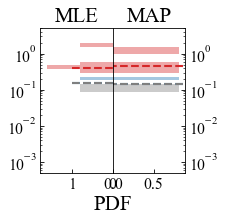

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.mixture import BayesianGaussianMixture as BGMM
import pickle

# ===== helpers =====
def _prep_log10_pos(arr, name):
    arr = np.asarray(arr, float).ravel()
    arr = arr[np.isfinite(arr) & (arr > 0)]
    if arr.size == 0:
        raise ValueError(f"{name}")
    return np.log10(arr)

def _safe_hist(log10_vals, bins_lin):
    hist, bins = np.histogram(log10_vals, density=True, bins=bins_lin)
    w = bins[1] - bins[0]
    centers = bins[:-1] + w/2
    return hist, centers, w

def _bounds_from_means_linear(mu_log10, k=3):
    mu = np.sort(np.asarray(mu_log10).ravel())[::-1]
    mids = (mu[:-1] + mu[1:]) / 2.0
    if mids.size == 0:
        return np.array([np.nan, np.nan, np.nan])
    while mids.size < k:
        mids = np.append(mids, mids[-1])
    return (10**mids[:k]).astype(float)

def _seg_max(hist, i0=None, i1=None):
    h = hist if (i0 is None and i1 is None) else hist[i0:i1]
    return 0.0 if h.size == 0 else float(np.max(h))

# ===== figure =====
gs = plt.GridSpec(1, 2, wspace=0, width_ratios=[1, 1])
fig = plt.figure(figsize=(2.5, 2.5))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

# ===== MLE =====
log10_mle = _prep_log10_pos(Bayes_MLE_ds, "Bayes_MLE_ds")

bgmm_mle = BGMM(
    n_components=4, max_iter=50, n_init=20, init_params='kmeans',
    random_state=1, weight_concentration_prior=20, mean_precision_prior=0.5,
    covariance_type='spherical', covariance_prior=0.3, degrees_of_freedom_prior=5
).fit(log10_mle[:, None])

labels_mle = bgmm_mle.predict(log10_mle[:, None])
mu_mle = bgmm_mle.means_.ravel()
var_mle = bgmm_mle.covariances_.ravel()
w_mle = bgmm_mle.weights_.ravel()

for i in range(4):
    print(np.count_nonzero(labels_mle == i))
    print('weight:', w_mle[i])
    print('mu:', 10**mu_mle[i])
    print('var:', var_mle[i])

bins_lin = np.linspace(-3, 0.5, 35)
hist_mle, centers_mle, bw_mle = _safe_hist(log10_mle, bins_lin)
yvals_mle = 10**centers_mle
hscale_mle = bw_mle * 2.3 * yvals_mle

bounds_mle = _bounds_from_means_linear(mu_mle, k=3)
bound1, bound2, bound3 = bounds_mle
globals()['bound1'] = bound1
globals()['bound2'] = bound2
globals()['bayesMLEbound1'] = bound1
globals()['bayesMLEbound2'] = bound2
globals()['bayesMLEbound3'] = bound3

index1 = int(np.searchsorted(yvals_mle, bound1, side='left'))
index2 = int(np.searchsorted(yvals_mle, bound2, side='left'))
index3 = int(np.searchsorted(yvals_mle, bound3, side='left'))

# barh
ax1.barh(yvals_mle[index1:], hist_mle[index1:], height=hscale_mle[index1:], color=colors[0], alpha=0.4)
ax1.barh(yvals_mle[index2:index1], hist_mle[index2:index1], height=hscale_mle[index2:index1], color=colors[1], alpha=0.4)
ax1.barh(yvals_mle[index3:index2], hist_mle[index3:index2], height=hscale_mle[index3:index2], color=colors[2], alpha=0.4)
# ax1.barh(yvals_mle[:index3], hist_mle[:index3], height=hscale_mle[:index3], color=colors[3], alpha=0.4)

# 축/스타일
ax1.invert_xaxis()
ax1.set_yscale('log')
ax1.set_ylim(0.0005, 5)
ax1.set_title('MLE')
ax1.tick_params(which='both', direction='in')

xspace2 = np.linspace(1, 0, 5)
for i in range(3):
    ax1.plot(xspace2, np.full_like(xspace2, 10**np.sort(mu_mle)[::-1][i]), '--', linewidth=2, color=colors[i])

max_pdf_val_mle = max(
    _seg_max(hist_mle, index1, None),
    _seg_max(hist_mle, index2, index1),
    _seg_max(hist_mle, index3, index2),
    _seg_max(hist_mle, None, index3),
)
ax1.set_xlim(max_pdf_val_mle * 1.1, 0)

# ===== MAP =====
log10_map = _prep_log10_pos(Bayes_MAP_ds, "Bayes_MAP_ds")

bgmm_map = BGMM(
    n_components=4, max_iter=50, n_init=20, init_params='kmeans',
    random_state=1, weight_concentration_prior=20, mean_precision_prior=0.5,
    covariance_type='spherical', covariance_prior=0.3, degrees_of_freedom_prior=5
).fit(log10_map[:, None])

labels_map = bgmm_map.predict(log10_map[:, None])
mu_map = bgmm_map.means_.ravel()
var_map = bgmm_map.covariances_.ravel()
w_map = bgmm_map.weights_.ravel()

for i in range(4):
    print(np.count_nonzero(labels_map == i))
    print('weight:', w_map[i])
    print('mu:', 10**mu_map[i])
    print('var:', var_map[i])

hist_map, centers_map, bw_map = _safe_hist(log10_map, bins_lin)
yvals_map = 10**centers_map
hscale_map = bw_map * 2.3 * yvals_map

bounds_map = _bounds_from_means_linear(mu_map, k=3)
bayesMAPbound1, bayesMAPbound2, bayesMAPbound3 = bounds_map
globals()['bayesMAPbound1'] = bayesMAPbound1
globals()['bayesMAPbound2'] = bayesMAPbound2
globals()['bayesMAPbound3'] = bayesMAPbound3

index1_map = int(np.searchsorted(yvals_map, bayesMAPbound1, side='left'))
index2_map = int(np.searchsorted(yvals_map, bayesMAPbound2, side='left'))
index3_map = int(np.searchsorted(yvals_map, bayesMAPbound3, side='left'))

ax2.barh(yvals_map[index1_map:], hist_map[index1_map:], height=hscale_map[index1_map:], color=colors[0], alpha=0.4)
ax2.barh(yvals_map[index2_map:index1_map], hist_map[index2_map:index1_map], height=hscale_map[index2_map:index1_map], color=colors[1], alpha=0.4)
ax2.barh(yvals_map[index3_map:index2_map], hist_map[index3_map:index2_map], height=hscale_map[index3_map:index2_map], color=colors[2], alpha=0.4)

ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.set_title('MAP')
ax2.set_xlabel('PDF')
ax2.xaxis.set_label_coords(0, -0.15)
ax2.tick_params(which='both', direction='in')

for i in range(3):
    ax2.plot(xspace2, np.full_like(xspace2, 10**np.sort(mu_map)[::-1][i]), '--', linewidth=2, color=colors[i])

max_pdf_val_mle = max(
    hist_mle[index1:].max(initial=0),
    hist_mle[index2:index1].max(initial=0),
    hist_mle[index3:index2].max(initial=0),
    hist_mle[:index3].max(initial=0)
)
ax1.set_xlim(max_pdf_val_mle * 1.1, 0)

max_pdf_val_map = max(
    hist_map[index1_map:].max(initial=0),
    hist_map[index2_map:index1_map].max(initial=0),
    hist_map[index3_map:index2_map].max(initial=0)
)
ax2.set_xlim(0, max_pdf_val_map * 1.1)

plt.show()

# ===== average transition matrix =====
P_avg = np.zeros((2, 2))
cnt = 0
for j in range(int(fnum)):
    pkl_path = f'{path}/results/MAP{j+1}_AIC.pkl'
    try:
        with open(pkl_path, 'rb') as f:
            temp = pickle.load(f)
        win = int(np.sqrt(max(len(temp)-1, 1)))
        tempD, tempP = ns_hmm.sample_sorting(temp, win)
        if len(tempD) == 2:
            if (globals()['bound1'] <= tempD[1]) and (globals()['bound2'] <= tempD[0] < globals()['bound1']):
                P_avg += tempP
                cnt += 1
    except FileNotFoundError:
        print(f"path not found: {pkl_path}")
    except Exception as e:
        print(f"exception ({pkl_path}): {e}")

if cnt > 0:
    P_avg /= cnt
# print(P_avg)
